# Problem sheet 4

Lynn Hansen, Jonathan Oel, Jannick Schulze, Elena Silvestre Roselló

## Problem 1

The Gaussian probability is written as $$P(x_i|\mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{-(x_i-\mu_i)^2/(2\sigma^2)},$$ with $x_i$ the data values in the bands and $\mu_i=Ax_{m,i}$ is an amplitude $A$ times the model data at that band $x_{m,i}$. For simplicity we can minimize the log probability $$\log P(x_1, ..., x_n|A, x_{m,i}, \sigma_i) = -\frac{n}{2}\log{2\pi}-\sum_i\log{\sigma_i}-\sum_i \frac{(x_i-Ax_{m,i})^2}{2\sigma_i^2}.$$

When minimizing the amplitude
$$\frac{\partial \log P}{\partial A}=-\sum_i \frac{1}{\sigma_i^2}(x_i-A x_{m,i})(-x_{m,i})\overset{!}{=}0.$$

The sigma is the same on each band, so the factor $\sigma^2$ can be taken out of the sum and neglected.

$$\sum_i x_i x_{m,i} = A \sum_i x_{m,i}^2$$
$$\frac{\sum_i  x_i x_{m,i}}{\sum_i x_{m,i}^2}=A$$

In a general case, however,
$$\sum_i \frac{x_i x_{m,i}}{\sigma_i^2} = A \sum_i \frac{x_{m,i}^2}{\sigma_i^2}$$
$$\frac{\sum_i \frac{x_i x_{m,i}}{\sigma_i^2}}{\sum_i \frac{x_{m,i}^2}{\sigma_i^2}}=A$$

We can see that the case with the uncertainty equal in all bands is equivalent to the general case setting $\sigma_i=1$ for all $i$.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [22]:
#We have Nbands=5
def A_errors (data, model, sigma):
    """For a given model, already redshift corrected, computes the amplitude of the maximum likelihood. 
    Includes the errors for the data points. A constant error is equivalent to no error information
    Input:
        data(np.array[Nbands, float]): mesaured galaxy information on every band
        model(np.array[Nbands, float]): modelled profile at the given bands
        sigma(np.array[Nbands, float]): linear error in the data
    Returns:
        A(float): amplitude of the model to match the data with maximum likelihood."""
    data = np.log10(data)
    model = np.log10(model)
    return np.sum(data*model/sigma**2)/np.sum(model*model/sigma**2)

def RMS_calc(gal, model, sigma):
    """Computes the root mean square (RMS) of a quantity with a model.
    Input:
        gal(np.array[Nbands, float]): mesaured galaxy information on every band
        model(np.array[Nbands, float]): modelled profile at the given bands
        sigma(np.array[Nbands, float]): linear error in the data
    Returns:
        RMS(float)"""
    gal = np.log10(gal)
    model = np.log10(model)
    return np.sqrt(np.sum((gal-model)**2/sigma**2))

Now let us study the general case, where $\sigma_i \neq 1$

The uncertainty can be obtained from the second derivative.
From
$$\frac{\partial \log P}{\partial A}=-\sum_i \frac{1}{\sigma_i^2}(x_i-A x_{m,i})(-x_{m,i})$$
we compute $$\frac{\partial^2 \log P}{\partial A^2}=-\sum_i \frac{x_{m,i}^2}{\sigma_i^2}.$$

The second derivative is, as expected, always negative, so it is a maximum. Since the different model parameters are uncorrelated 
$$\sigma^2(\hat{A}_{\mathrm{MLE}})=-\left(\frac{\partial^2 \log P}{\partial A^2}\right)^{-1}=\frac{1}{\sum_i \frac{x_{m,i}^2}{\sigma_i^2}}.$$


In [60]:
#A catalogue has Ngal galaxies

def Minimum_distances(catalog, errors, true_z, plot_profile = []):
    """Computes the best estimate of amplitude and redshift for a catalogue of galaxies, compares the redshift with a given true redshift and plots a subsample of the catalogue.
    Input:
        catalog(np.array[(Ngal,Nbands), float]): Photometric observations of a list of galaxies on several bands
        errors(np.array[(Ngal,Nbands), float]): linear error in the data from the catalogue
        true_z(np.array[(Ngal), float]): redshift information from spectroscopic measurements for every galaxy
        plot_profile(np.array[?, int]): indices of the galaxies from which a plot must be created 
    Returns:
        """
    #Get model data and filters
    path = "data/k_nmf_derived.newdefault.fits"
    filters = np.loadtxt('data/bandfilters.txt')
    temps = fits.open(path)
    tspec = temps[1].data
    lam = temps[11].data

    #Redshifts to for corrections to the model
    z_list = np.arange(0,1.5,step=0.01) 
    #Number of galaxies to consider
    galaxies = np.shape(catalog)[0]
    #Initialize the count of redshifts
    z_measured = np.zeros(galaxies)
    
    #Compute for every galaxy the best amplitude and redshift
    for k in range(galaxies):
        gal = catalog[k]
        #Initialize the amplitude and the root mean square for the different redshifts
        Amp = np.zeros(len(z_list))
        RMS = np.zeros(len(z_list))

        #Consider the redshift corrections
        for  j, z in enumerate(z_list):
            model = np.zeros(5)
            #Redshift in lambda
            lam_new = lam*(1+z)
            template = tspec[0]
            for i in range(5):
                inds = np.logical_and(lam_new > filters[i], lam_new < filters[i+1])
                model[i] = template[inds].mean()

            #Computed for the given redshift the maximum likelihood amplitude and the RMS of the data
            
            Amp[j] = A_errors(gal, model, errors[k])
            RMS[j] = RMS_calc(gal, model*Amp[j], errors[k])

        #Find the amplitude and redshift that minimize the RMS
        Amp_min_RMS = Amp[RMS==min(RMS)]
        z_min_RMS = z_list[RMS==min(RMS)]
        #Add the obtained z to the count
        z_measured[k] = z_min_RMS

        #Plot the subsample
        if k in plot_profile:
            print(f'Galaxy {k}:')
            print(f'A = {Amp_min_RMS}')
            print(f'z = {z_min_RMS}')
            
            for i in range(5):
                inds = np.logical_and( lam*(1+z_min_RMS) > filters[i], lam*(1+z_min_RMS)< filters[i+1])
                model[i] = template[inds].mean()
            mufilters = (filters[1:] + filters[:-1]) * .5
            #Model
            plt.plot(lam*(1+z_min_RMS), np.log10(template)*Amp_min_RMS, label = 'Spectrum', color='#AE7182', linewidth=2)
            if np.sum(errors[k]/len(errors[k])) < 1: 
                plt.errorbar(mufilters, np.log10(model)*Amp_min_RMS, yerr=errors[k],marker='.', markersize=9, linestyle='None', label = f'Model {z_min_RMS}')
            else:
                plt.scatter(mufilters, np.log10(model)*Amp_min_RMS, linestyle='None', label = f'Model {z_min_RMS}', c ='r')
            #Observation
            plt.plot(mufilters, np.log10(gal) ,marker='o', markersize=9, linestyle='None', mfc = 'none', label = f'Observed data {true_z[k]}')

            plt.xlabel(r'Wavelength in $\AA$')
            plt.ylabel(f'Flux')
            plt.xlim(0, 12500)
            plt.legend(frameon=False, loc = (-1,0))
            plt.show()

    #Plot a histogram of the redshifts
    plt.hist(z_measured, len(z_list))
    plt.xlabel('z')
    plt.ylabel('Galaxy count')
    plt.show()
    
    #Plot the scatter of photometric and spectrosocpic redshift
    plt.scatter(true_z[:galaxies],z_measured)
    plt.xlabel('Spectroscopic z')
    plt.ylabel('Photometric z')
    plt.show()



ii) and iii) With catalog 1 without errors compute photometric redshift and compare

Galaxy 0:
A = [0.99818379]
z = [0.25]


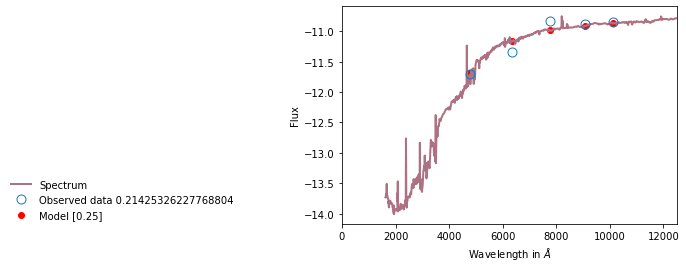

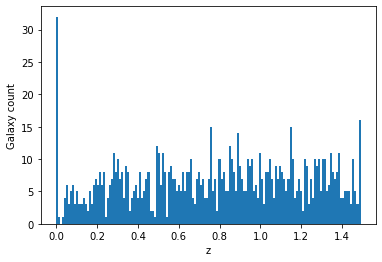

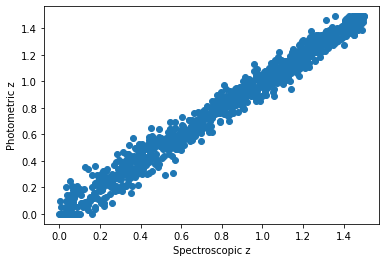

In [61]:
catalog1 = np.loadtxt('data/catalog1.txt')

#Give a value of 1 so it won't be considered for the error estimation
errors = np.full((len(catalog1),5), 1)
        
true_z1 = np.loadtxt('data/redshifts1.txt')
#Every row is a galaxy, every column a band

#Plot as an example the first galaxy
Minimum_distances(catalog1, errors, true_z1, [0])

marker='.',markersize=9,First the modelled profile of one of the galaxies is shown, overlayed with the model val. Tehre it can be seen that it follows the overall trend but it does not manage to fit the strong emission lines, that are averaged over the bands.

The redshifts we calculated from photometric observations of the galaxies are compared to spectroscopic redshifts in the above plot. 


If we increased the number of bands, both methods should converge to the same redshift for each galaxy such that the data points would follow a straight line with a slope of $1$. From the plot, one can observe a linear correlation between these two different methods of redshift determination as it is expected. Nevertheless there is large scatter in each bin of the photometric redshifts which is a result of this method being much more inaccurate than the determination of redshift via spectroscopy. This scatter stems mainly from the finite width of the redshift bins. Other effects that could add up are different intrinsic galaxy profiles and further uncertainties of the flux measurements in the different filters.

## Problem 2:

Add errors for every data point and compare to the obtained results

Catalog 1:

(1000, 5)
Galaxy 206:
A = [0.99866977]
z = [0.]


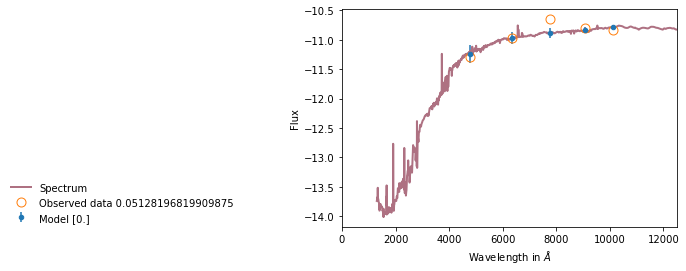

Galaxy 499:
A = [0.9996137]
z = [1.13]


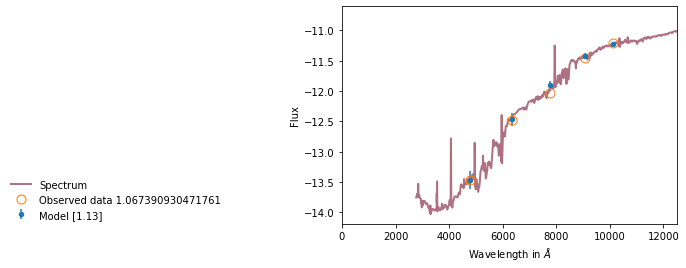

Galaxy 705:
A = [0.99993129]
z = [0.73]


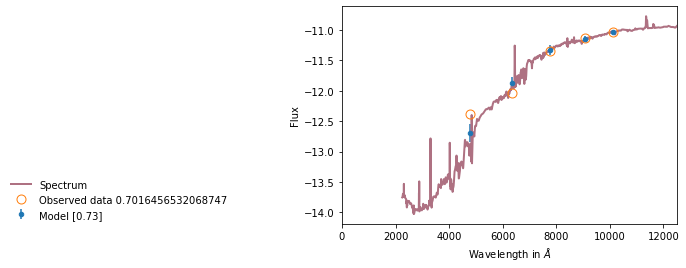

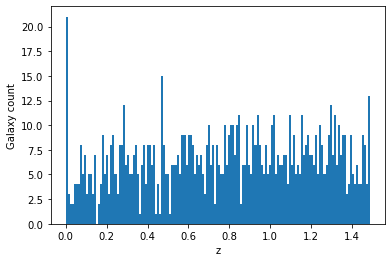

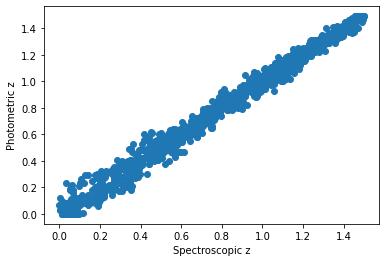

In [64]:
#Catalog 1
print('Catalog 1:\n')

catalog1 = np.loadtxt('data/catalog1.txt')
sigma1_log = np.array([0.15, 0.1, 0.08, 0.05, 0.03])
sigma1 = np.full( (len(catalog1),5), 1)*sigma1_log
print(np.shape(sigma1))
true_z1= np.loadtxt('data/redshifts1.txt')

#Random sample from which create profiles
plotting_sample = np.random.randint(0, high=np.shape(catalog1)[0]+1, size=3, dtype=int)

Minimum_distances(catalog1, sigma1, true_z1, plotting_sample)



Catalog 2:

Galaxy 28:
A = [1.00230001]
z = [0.93]


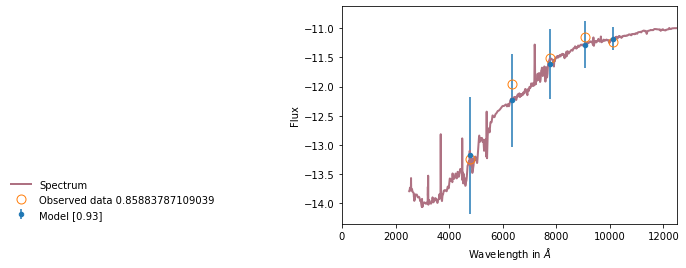

Galaxy 267:
A = [0.99883937]
z = [1.32]


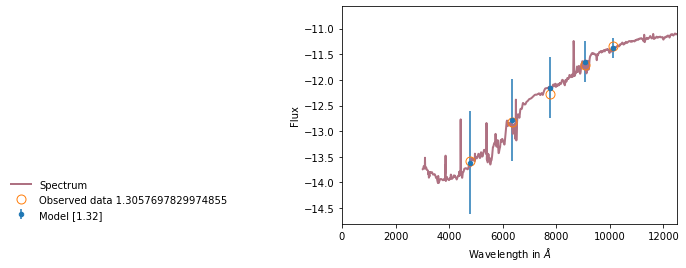

Galaxy 418:
A = [0.99947075]
z = [0.62]


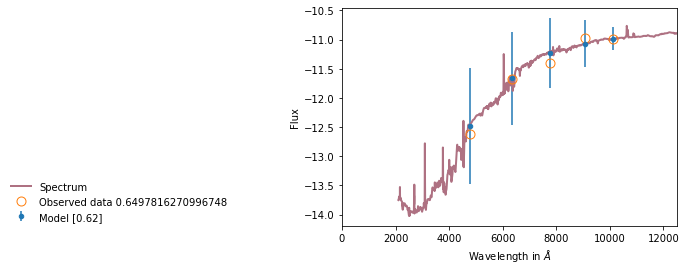

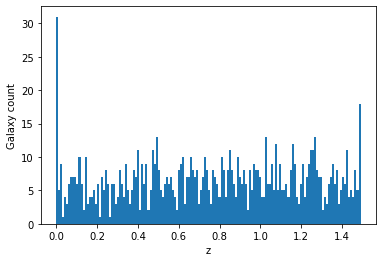

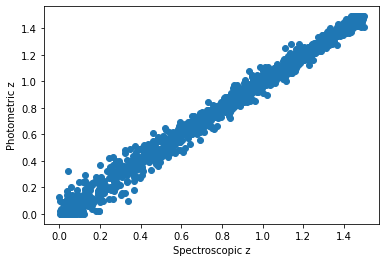

In [62]:
#Catalog 2
print('Catalog 2:\n')

sigma2_log = np.array([1.0, 0.8, 0.6, 0.4, 0.2])
catalog2 = np.loadtxt('data/catalog2.txt')
sigma2 = np.full( (len(catalog2),5), 1)*sigma2_log
true_z2= np.loadtxt('data/redshifts2.txt')

#Random sample from which create profiles
plotting_sample = np.random.randint(0, high=np.shape(catalog2)[0]+1, size=3, dtype=int)

Minimum_distances(catalog2, sigma2, true_z2, plotting_sample)



Catalog 3:

Galaxy 292:
A = [1.00156064]
z = [0.65]


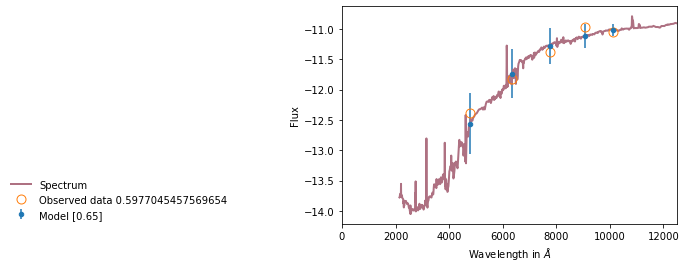

Galaxy 553:
A = [0.99816369]
z = [0.52]


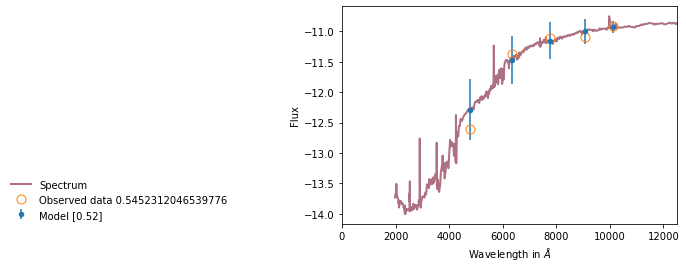

Galaxy 772:
A = [0.99958676]
z = [0.06]


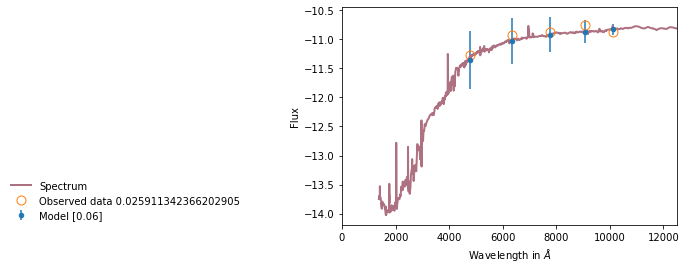

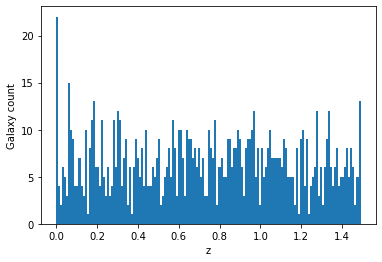

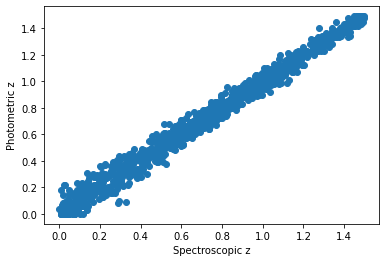

In [63]:
#Catalog 3
print('Catalog 3:\n')

sigma3_log = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
catalog3 = np.loadtxt('data/catalog3.txt')
sigma3 = np.full( (len(catalog3),5), 1)*sigma3_log
true_z3= np.loadtxt('data/redshifts3.txt')

#Random sample from which create profiles
plotting_sample = np.random.randint(0, high=np.shape(catalog3)[0]+1, size=3, dtype=int)


Minimum_distances(catalog3, sigma3, true_z3, plotting_sample)

We can see that when there is a bigger error for some bands, those points are fitted worse. These are probably galaxies for which the assumed model spectrum does not apply so well. For all catalogs the linear correlation between photometric and spectroscopic redshifts is reobtained and the scatter of the photometric redshifts is slightly reduced, especially for intermediate redshifts, compared to the first task where we assumed equal errors on all filter bands. Therefore the uncertainty is greener redshift bands is likely higher, as chosen in the uncertainty model.